### 1. Understanding Time Series Data

A time series is simply a sequence of observations taken at regular time intervals. Examples include:

* Daily stock prices
* Monthly sales figures
* Hourly temperature readings
* Quarterly GDP values

What makes time series data special is that the order of observations matters. Unlike many other data analysis problems, the sequence and timing of values contain crucial information.

### 2. Getting Started with Python for Time Series Analysis

In [1]:
# Data handling and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Time series analysis tools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### 3. Loading and Exploring the Data

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
airpass = pd.read_csv('/content/drive/MyDrive/ML 101/Practical/AirPassengers.csv')
airpass.head(5)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
airpass.shape

(144, 2)

In [5]:
airpass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [6]:
# Rename the column for clarity
airpass.rename(columns={'#Passengers': 'Passengers'}, inplace=True)

# Convert 'Month' to datetime format
airpass['Month'] = pd.to_datetime(airpass['Month'])

# Set the date as the index
airpass_indexed = airpass.set_index('Month')

# Display the first few rows
airpass_indexed.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [7]:
airpass.tail()

,Month,Passengers
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


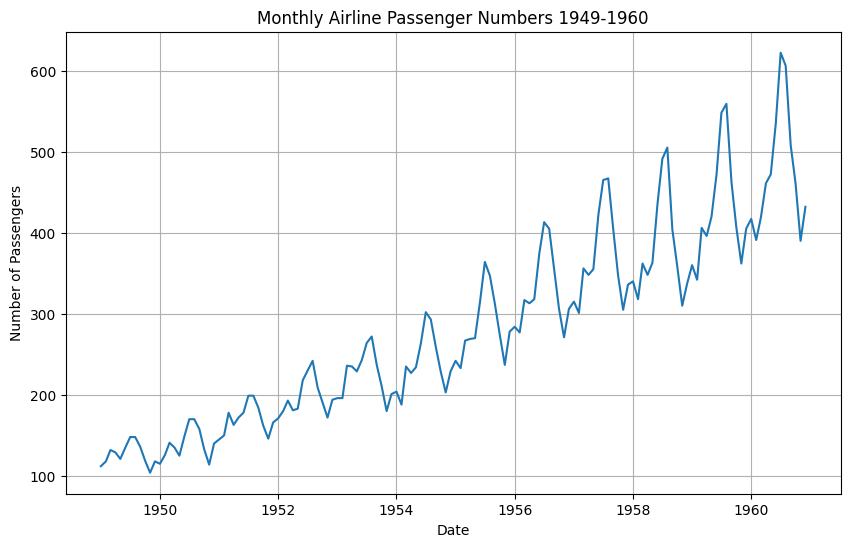

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(airpass_indexed)
plt.title('Monthly Airline Passenger Numbers 1949-1960')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.show()

#### What to Look for in the Plot
When examining a time series plot, pay attention to these patterns:

* Trend: Is there a long-term increase or decrease?
* Seasonality: Are there regular patterns that repeat at fixed intervals?
* Cycles: Are there patterns that occur but not at fixed frequencies?
* Irregular fluctuations: Random variations that don't fit the other patterns

In our airline passenger data, we can see:

* An upward trend (passenger numbers are increasing over time)
* Clear seasonality (peaks and valleys that repeat annually)
* The amplitude of seasonal fluctuations seems to increase over time

### 4. Stationarity: A Critical Concept

One of the most important concepts in time series forecasting is stationarity. A stationary time series has statistical properties that don't change over time:

* Constant mean
* Constant variance
* No seasonal patterns

Why is stationarity important? Most time series forecasting methods assume that the data is stationary. If it's not, we need to transform it first.
Let's check if our data is stationary by:

* Visually examining rolling statistics
* Performing a statistical test (Augmented Dickey-Fuller test)



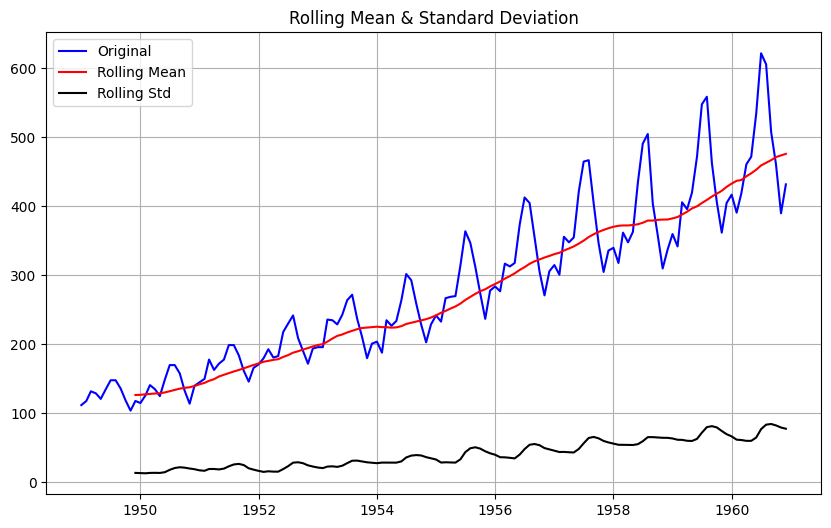

Results of Dickey-Fuller Test:
Test Statistic              0.815369
p-value                     0.991880
#Lags Used                 13.000000
Number of Observations    130.000000
Critical Value (1%)        -3.481682
Critical Value (5%)        -2.884042
Critical Value (10%)       -2.578770
dtype: float64

Conclusion: The time series is not stationary (fail to reject null hypothesis)


In [9]:
def test_stationarity(timeseries):
    """Test for stationarity using rolling statistics and Dickey-Fuller test."""

    # Calculate rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # Plot rolling statistics
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid(True)
    plt.show()

    # Perform Augmented Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries.dropna(), autolag='AIC')

    dfresult = pd.Series(
        result[0:4],
        index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations']
    )

    for key, value in result[4].items():
        dfresult[f'Critical Value ({key})'] = value

    print(dfresult)

    # Interpret the results
    if result[1] <= 0.05:
        print("\nConclusion: The time series is stationary (reject null hypothesis)")
    else:
        print("\nConclusion: The time series is not stationary (fail to reject null hypothesis)")

# Test stationarity on our passenger data
test_stationarity(airpass_indexed)

**Interpreting the Results
In the Augmented Dickey-Fuller test:**

* The null hypothesis is that the time series is not stationary
* If the p-value is less than 0.05, we reject the null hypothesis (the series is stationary)
* If the p-value is greater than 0.05, we fail to reject the null hypothesis (the series is not stationary)

Looking at our results, we can see that our airline passenger data is not stationary. Both the mean and variance are increasing over time, and there's clear seasonality.

### 5. Making Time Series Stationary

Now that we know our data isn't stationary, let's transform it. Common techniques include:

* Logarithmic transformation: Helps stabilize the variance
* Differencing: Helps eliminate trend and seasonality
* Decomposition: Separating the series into components


#### 5.1 Logarithmic Transformation

First, let's apply a log transformation to stabilize the variance:


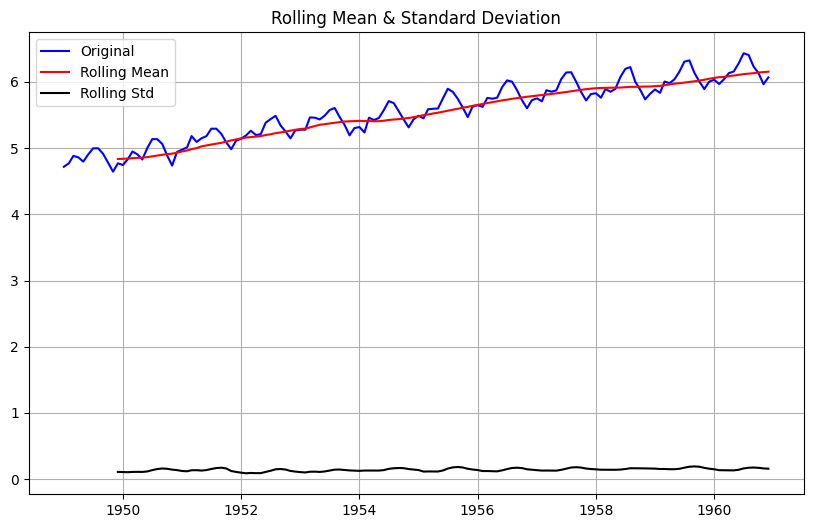

Results of Dickey-Fuller Test:
Test Statistic             -1.717017
p-value                     0.422367
#Lags Used                 13.000000
Number of Observations    130.000000
Critical Value (1%)        -3.481682
Critical Value (5%)        -2.884042
Critical Value (10%)       -2.578770
dtype: float64

Conclusion: The time series is not stationary (fail to reject null hypothesis)


In [10]:
# Apply log transformation
airpass_log = np.log(airpass_indexed)

# Check stationarity of the log-transformed data
test_stationarity(airpass_log)

The variance (rolling std) is more stable now, but the series still shows an upward trend and seasonality.

#### 5.2 Differencing

Next, let's try differencing, which involves subtracting the previous value from the current value:

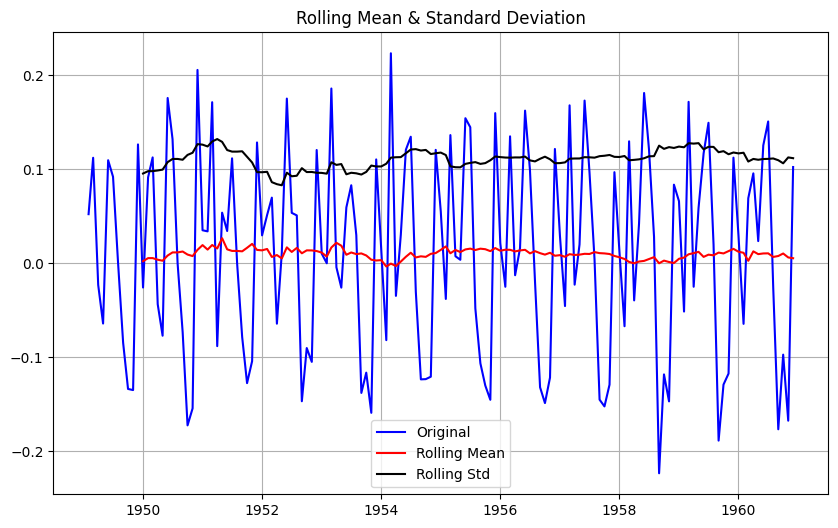

Results of Dickey-Fuller Test:
Test Statistic             -2.717131
p-value                     0.071121
#Lags Used                 14.000000
Number of Observations    128.000000
Critical Value (1%)        -3.482501
Critical Value (5%)        -2.884398
Critical Value (10%)       -2.578960
dtype: float64

Conclusion: The time series is not stationary (fail to reject null hypothesis)


In [11]:
# Apply differencing to the log-transformed data
airpass_log_diff = airpass_log.diff()

# Remove NaN values created by differencing
airpass_log_diff.dropna(inplace=True)

# Check stationarity
test_stationarity(airpass_log_diff)

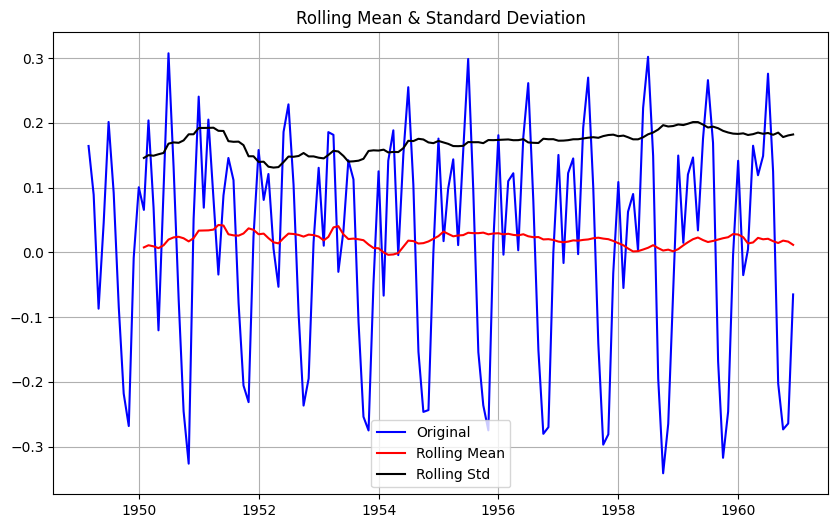

Results of Dickey-Fuller Test:
Test Statistic             -3.167907
p-value                     0.021919
#Lags Used                 11.000000
Number of Observations    130.000000
Critical Value (1%)        -3.481682
Critical Value (5%)        -2.884042
Critical Value (10%)       -2.578770
dtype: float64

Conclusion: The time series is stationary (reject null hypothesis)


In [12]:
# Apply differencing to the log-transformed data
airpass_log_diff = airpass_log.diff(2)

# Remove NaN values created by differencing
airpass_log_diff.dropna(inplace=True)

# Check stationarity
test_stationarity(airpass_log_diff)

Now our data looks much more stationary! The mean is more constant, and the Dickey-Fuller test confirms this improvement.

#### 5.3 Seasonal Decomposition

Let's also try decomposing our time series into its components:

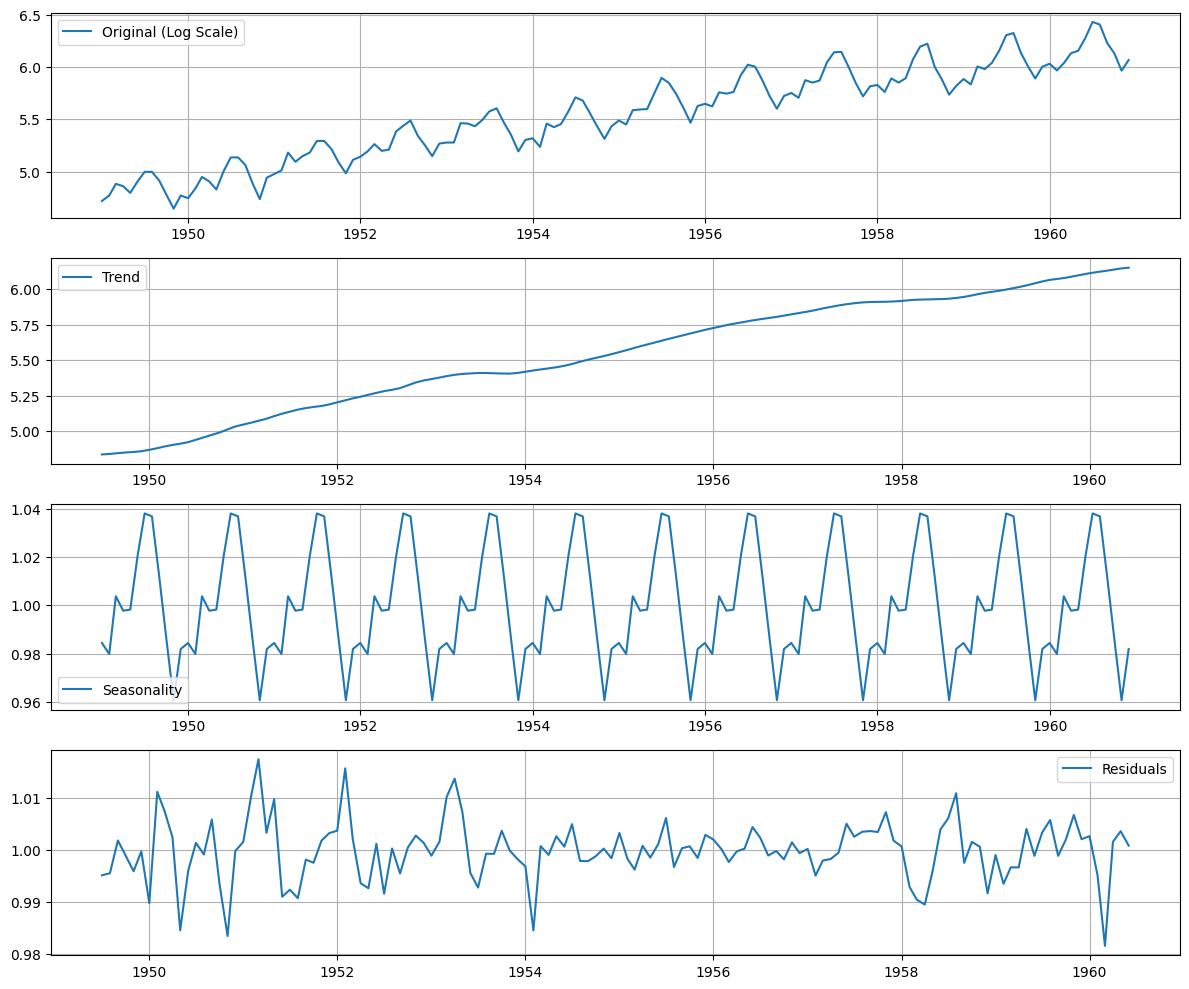

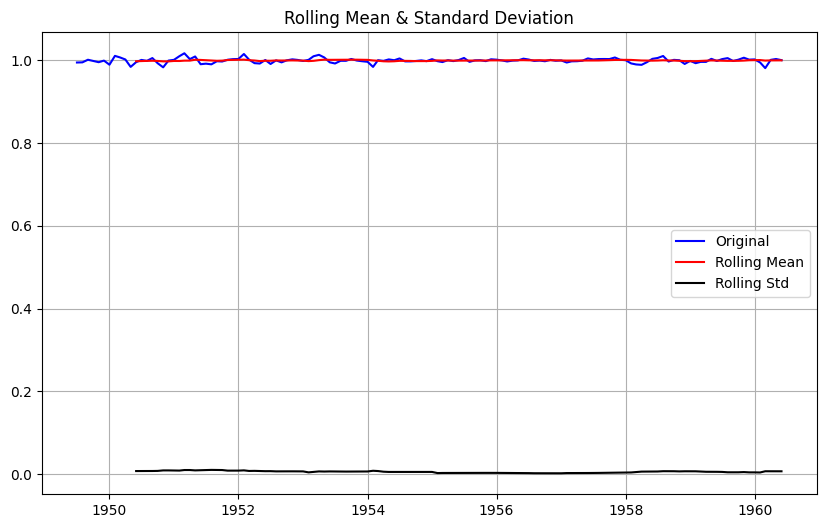

Results of Dickey-Fuller Test:
Test Statistic           -6.931283e+00
p-value                   1.082484e-09
#Lags Used                7.000000e+00
Number of Observations    1.240000e+02
Critical Value (1%)      -3.484220e+00
Critical Value (5%)      -2.885145e+00
Critical Value (10%)     -2.579359e+00
dtype: float64

Conclusion: The time series is stationary (reject null hypothesis)


In [13]:
# Decompose the time series
decomposition = seasonal_decompose(airpass_log, model='multiplicative')

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the components
plt.figure(figsize=(12, 10))

plt.subplot(411)
plt.plot(airpass_log, label='Original (Log Scale)')
plt.legend(loc='best')
plt.grid(True)

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.grid(True)

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.grid(True)

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()

# Check if residuals are stationary
residual_clean = residual.dropna()
test_stationarity(pd.DataFrame(residual_clean))

The residual component (what remains after removing trend and seasonality) should be stationary, which means it's suitable for forecasting.

In [14]:
pd.concat([airpass, airpass.diff(), airpass.diff(2)], axis=1)

,Month,Passengers,Month,Passengers,Month,Passengers
0,1949-01-01,112,NaT,NaN,NaT,NaN
1,1949-02-01,118,31 days,6.0,NaT,NaN
2,1949-03-01,132,28 days,14.0,59 days,20.0
3,1949-04-01,129,31 days,-3.0,59 days,11.0
4,1949-05-01,121,30 days,-8.0,61 days,-11.0
...,...,...,...,...,...,...
139,1960-08-01,606,31 days,-16.0,61 days,71.0
140,1960-09-01,508,31 days,-98.0,62 days,-114.0
141,1960-10-01,461,30 days,-47.0,61 days,-145.0
142,1960-11-01,390,31 days,-71.0,61 days,-118.0


### 6. Determining ARIMA Parameters

Taking differencing between each point and the previous one, we expect to see a constant value over time. Basic form of ARIMA is order of (1,1,1).

Now that we have stationary data, we can use an ARIMA model for forecasting. ARIMA stands for:

* AR: AutoRegressive (p parameter)
* I: Integrated (d parameter)
* MA: Moving Average (q parameter)

1. Autocorrelation is the correlation of a value with itself.

2. ACF: measure autocorrelation as lag varies; example: relationshiop between y_t and y_{t-3} including all intermediate relationships like y_{t-2} and y_{t-1}.

To determine the appropriate values for these parameters, we use:

* ACF (AutoCorrelation Function) to help determine the MA order (q) (indirect effect of previous values on current value).
* PACF (Partial AutoCorrelation Function) to help determine the AR order (p) (direct effect of past value on current value).
* The order of differencing we applied determines d (typically 1 if we differenced once)


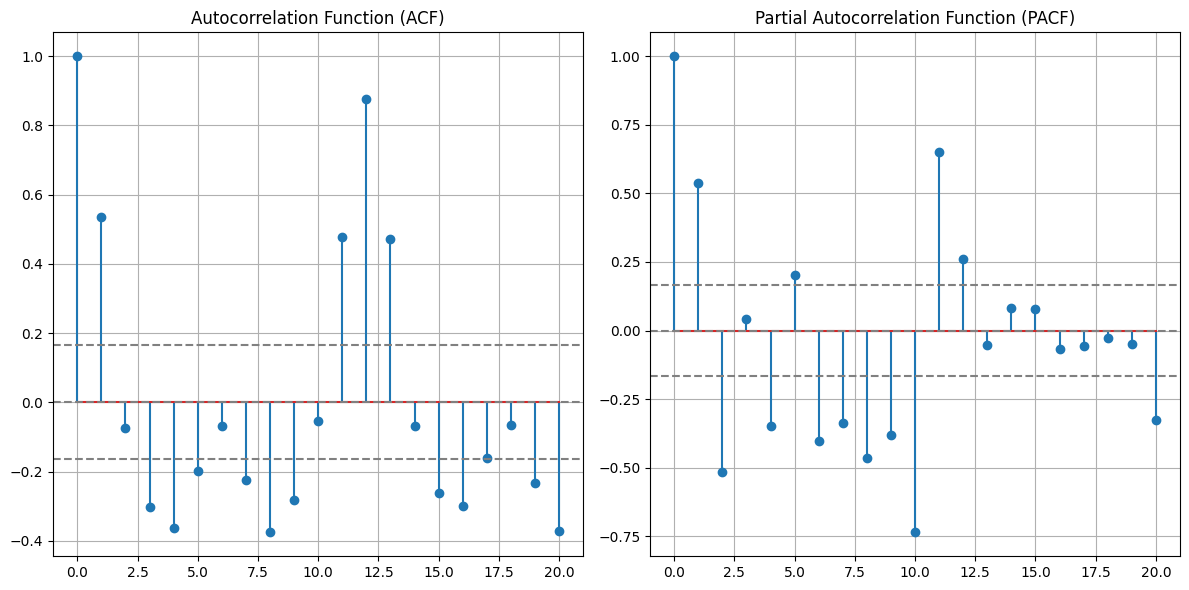

In [15]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))

# ACF
plt.subplot(121)
acf_plot = acf(airpass_log_diff, nlags=20)
plt.stem(range(len(acf_plot)), acf_plot)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(airpass_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(airpass_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)

# PACF
plt.subplot(122)
pacf_plot = pacf(airpass_log_diff, nlags=20, method='ols')
plt.stem(range(len(pacf_plot)), pacf_plot)
plt.axhline(y=0, linestyle='--', color='gray')

## statistical significance lines
plt.axhline(y=-1.96/np.sqrt(len(airpass_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(airpass_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)

plt.tight_layout()
plt.show()

#### Interpreting ACF and PACF

* ACF: Shows correlation of the series with itself at different lags
* PACF: Shows correlation of the series with itself at different lags after removing the effects of previous lags

Typically:

* If ACF drops quickly and PACF decreases gradually, use an MA(q) model
* If PACF drops quickly and ACF decreases gradually, use an AR(p) model
* If both decrease gradually, use ARMA(p,q) model

Based on our plots, we'll try different ARIMA models:

* ARIMA(2,1,0): AR model with p=2, d=1, q=0
* ARIMA(0,1,2): MA model with p=0, d=1, q=2
* ARIMA(2,1,2): Combined ARMA model with p=2, d=1, q=2

### 7. Building and Evaluating ARIMA Models

Let's build and compare different ARIMA models:


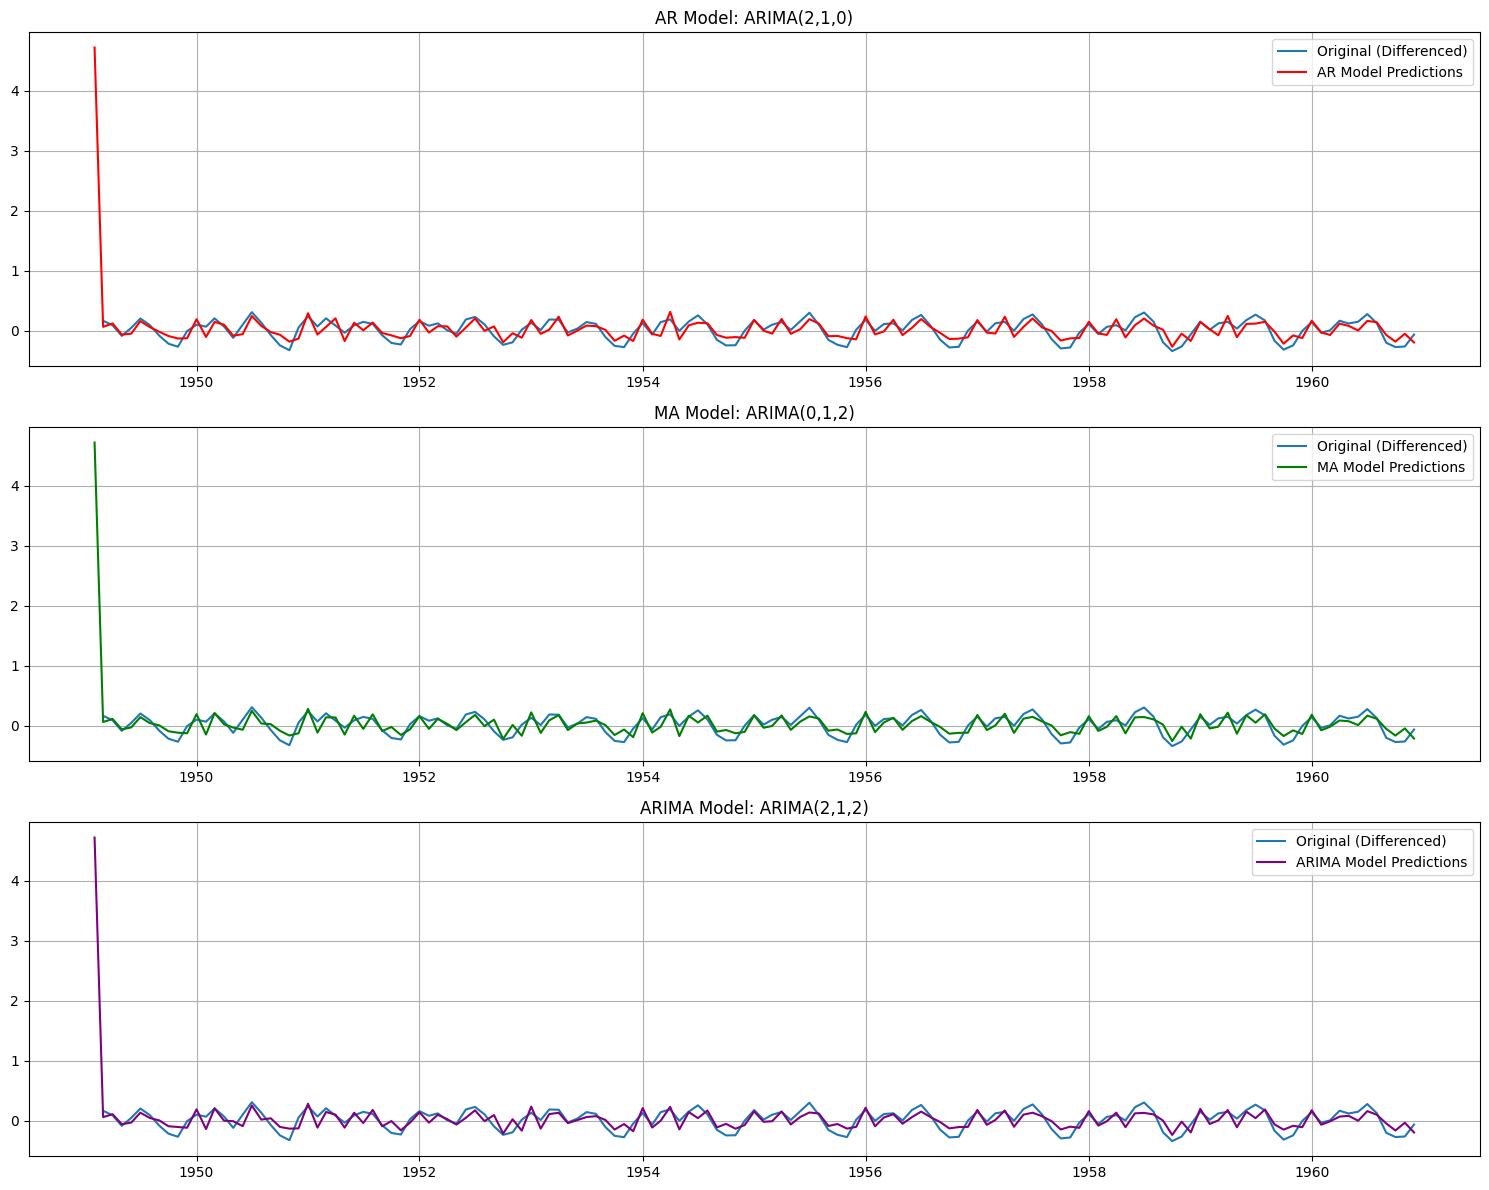


Model Comparison:
--------------------------------------------------
AR(2,1,0) AIC: -238.52
AR(2,1,0) BIC: -229.63
--------------------------------------------------
MA(0,1,2) AIC: -240.85
MA(0,1,2) BIC: -231.96
--------------------------------------------------
ARIMA(2,1,2) AIC: -247.78
ARIMA(2,1,2) BIC: -232.97
--------------------------------------------------


In [16]:
# AR Model: ARIMA(2,1,0)
model_ar = ARIMA(airpass_log, order=(2, 1, 0))
results_ar = model_ar.fit()

# MA Model: ARIMA(0,1,2)
model_ma = ARIMA(airpass_log, order=(0, 1, 2))
results_ma = model_ma.fit()

# ARIMA Model: ARIMA(2,1,2)
model_arima = ARIMA(airpass_log, order=(2, 1, 2))
results_arima = model_arima.fit()

# Plot actual vs. fitted values for each model
plt.figure(figsize=(15, 12))

# AR model
plt.subplot(311)
plt.plot(airpass_log_diff, label='Original (Differenced)')
plt.plot(results_ar.fittedvalues.diff().dropna(), color='red', label='AR Model Predictions')
plt.title('AR Model: ARIMA(2,1,0)')
plt.legend(loc='best')
plt.grid(True)

# MA model
plt.subplot(312)
plt.plot(airpass_log_diff, label='Original (Differenced)')
plt.plot(results_ma.fittedvalues.diff().dropna(), color='green', label='MA Model Predictions')
plt.title('MA Model: ARIMA(0,1,2)')
plt.legend(loc='best')
plt.grid(True)

# ARIMA model
plt.subplot(313)
plt.plot(airpass_log_diff, label='Original (Differenced)')
plt.plot(results_arima.fittedvalues.diff().dropna(), color='purple', label='ARIMA Model Predictions')
plt.title('ARIMA Model: ARIMA(2,1,2)')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()

# Compare model metrics
print("\nModel Comparison:")
print("-" * 50)
for name, model in [("AR(2,1,0)", results_ar), ("MA(0,1,2)", results_ma), ("ARIMA(2,1,2)", results_arima)]:
    print(f"{name} AIC: {model.aic:.2f}")
    print(f"{name} BIC: {model.bic:.2f}")
    print("-" * 50)


The model with the lowest AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) is generally considered the best.

### 8. Making Predictions

Now let's use our best model to make predictions:

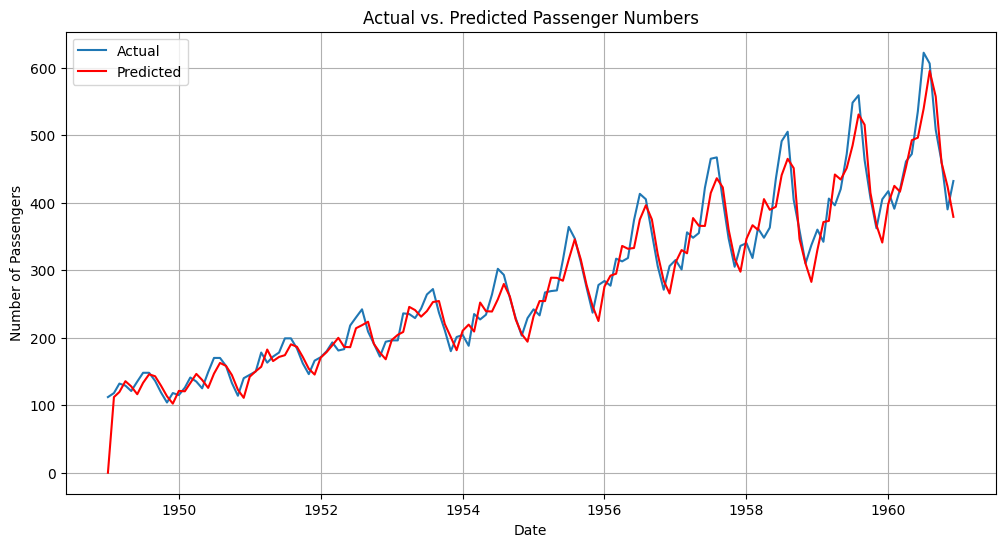

In [17]:
# Alternative approach: Use ARIMA directly on the original data
model_direct = ARIMA(airpass_indexed, order=(2, 1, 2))
results_direct = model_direct.fit()

# Get predictions
predictions_direct = results_direct.predict(start=airpass_indexed.index[0], end=airpass_indexed.index[-1])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(airpass_indexed, label='Actual')
plt.plot(predictions_direct, color='red', label='Predicted')
plt.title('Actual vs. Predicted Passenger Numbers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [18]:
train_data, test_data = airpass_indexed[:-12], airpass_indexed[-12:]

In [19]:
model_direct = ARIMA(train_data, order=(2, 1, 2))
results_direct = model_direct.fit()

# Get predictions
predictions_direct = results_direct.predict(start=test_data.index[0], end=test_data.index[-1])
predictions_direct

,predicted_mean
1960-01-01,411.312453
1960-02-01,430.812660
1960-03-01,457.433605
1960-04-01,483.661492
1960-05-01,502.616754
1960-06-01,509.821046
1960-07-01,504.207054
1960-08-01,488.158647
1960-09-01,466.639307
1960-10-01,445.702753


In [20]:
pd.concat([predictions_direct, test_data],axis=1)

,predicted_mean,Passengers
1960-01-01,411.312453,417
1960-02-01,430.812660,391
1960-03-01,457.433605,419
1960-04-01,483.661492,461
1960-05-01,502.616754,472
1960-06-01,509.821046,535
1960-07-01,504.207054,622
1960-08-01,488.158647,606
1960-09-01,466.639307,508
1960-10-01,445.702753,461


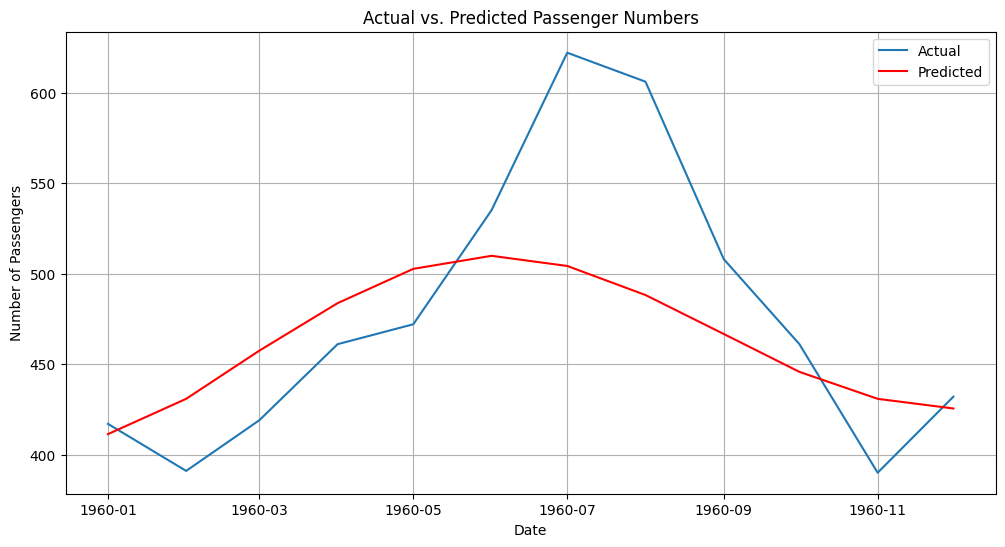

In [21]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions_direct, color='red', label='Predicted')
plt.title('Actual vs. Predicted Passenger Numbers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend(loc='best')
plt.grid(True)
plt.show()

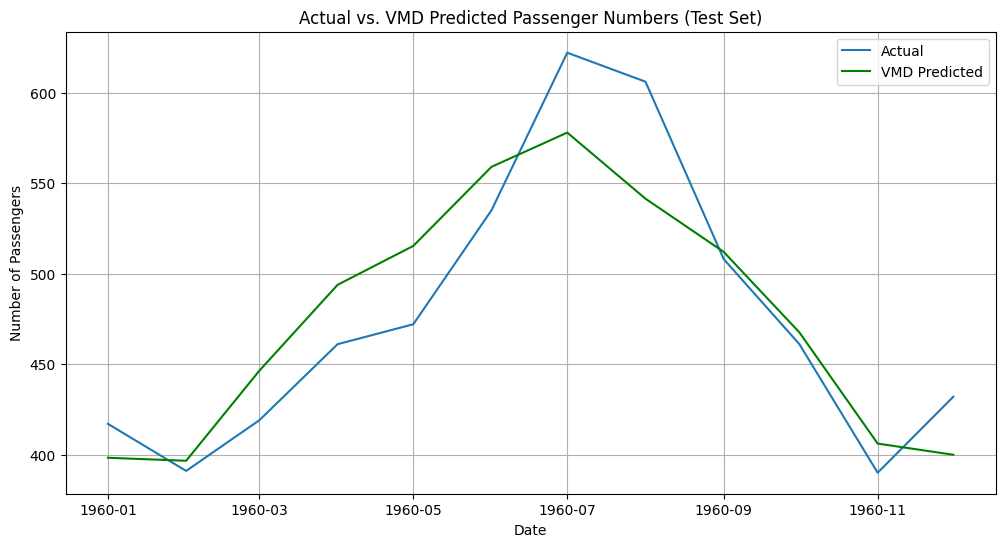

VMD Predictions for Test Data:


,VMD_Predictions
Month,
1960-01-01,398.261217
1960-02-01,396.597572
1960-03-01,446.364618
1960-04-01,493.788483
1960-05-01,515.285685
1960-06-01,558.978781
1960-07-01,577.874249
1960-08-01,541.364143
1960-09-01,511.979005


In [22]:
# prompt: create a variational mode decomposition function to make the predictions of the test_data

!pip install vmdpy
from vmdpy import VMD
def vmd_prediction(data, alpha, tau, K, DC, init, tol):
  """
    Performs Variational Mode Decomposition (VMD) on the input data and makes predictions.

    Args:
        data (pd.Series or np.array): The time series data for which to make predictions.
        alpha (float): The balancing parameter of the mode fidelity constraint.
        tau (float): The time-step of the dual ascent ( pick 0 for noise-free ).
        K (int): The number of modes to be extracted.
        DC (int): Determines if the first mode is a DC component (0/1).
        init (int): Determines the initialization method (0 for random, 1 for peaks, 2 for user-defined).
        tol (float): Tolerance of convergence criterion.

    Returns:
        np.array: The reconstructed signal from the VMD modes, serving as the prediction.
    """
  # Apply VMD
  # u: the collection of the decomposed modes
  # u_hat: the spectra of the modes
  # omega: the center frequencies of the modes
  u, u_hat, omega = VMD(data.values, alpha, tau, K, DC, init, tol)

  # Reconstruct the signal from the modes
  reconstructed_signal = np.sum(u, axis=0)

  return reconstructed_signal

# Example Usage (using the test_data from the previous code)
# You might need to tune the VMD parameters (alpha, tau, K, etc.) for your specific data.
# These values are just placeholders.
alpha = 2000  # moderate bandwidth constraint
tau = 0.       # noise-free
K = 3          # 3 modes
DC = 0         # no DC part imposed
init = 1       # initialize omegas uniformly
tol = 1e-7

vmd_predictions_test = vmd_prediction(test_data['Passengers'], alpha, tau, K, DC, init, tol)

# Create a DataFrame for the VMD predictions with the same index as test_data
vmd_predictions_df = pd.DataFrame(vmd_predictions_test, index=test_data.index, columns=['VMD_Predictions'])

# Plot the actual test data and VMD predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data['Passengers'], label='Actual')
plt.plot(vmd_predictions_df['VMD_Predictions'], color='green', label='VMD Predicted')
plt.title('Actual vs. VMD Predicted Passenger Numbers (Test Set)')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Print the predictions
print("VMD Predictions for Test Data:")
vmd_predictions_df

In [24]:
# from neuralforecast import NeuralForecast
# from neuralforecast.models import NHITS
# from neuralforecast.losses.pytorch import MAE
# from neuralforecast.losses.pytorch import MSE
# import pandas as pd # Import pandas for DataFrame operations

# # Assuming 'airpass_indexed' is your original time series DataFrame with 'Month' as index and 'Passengers' as the value column
# # and 'test_data' is your test set created earlier.

# # NeuralForecast requires the data in a specific format:
# # 'unique_id', 'ds', and 'y'
# # 'unique_id': Identifier for each time series (we have only one)
# # 'ds': Datestamp (the index of our DataFrame)
# # 'y': Value (the 'Passengers' column)

# # Prepare the data for NeuralForecast
# airpass_nf = train_data.reset_index().rename(columns={'Month': 'ds', 'Passengers': 'y'})
# airpass_nf['unique_id'] = 'AirPassengers'

# # Split into train and test sets (NeuralForecast takes DataFrame directly)
# # Ensure the test set is structured the same way
# test_data_nf = test_data.reset_index().rename(columns={'Month': 'ds', 'Passengers': 'y'})
# test_data_nf['unique_id'] = 'AirPassengers'

# # Define the horizon for the test set (how many steps ahead to predict)
# horizon = len(test_data_nf)

# # Initialize the NHITS model
# # You might need to tune these parameters based on your data and requirements
# # Removed custom stack_types, n_blocks, n_layers, n_mlp_layers, and widths
# # to use the model's default configurations.
# models = [NHITS(input_size=2 * horizon,  # A common heuristic for input size
#                  h=horizon,
#                 # dropout=0.1,
#                  loss=MAE(),
#                  max_steps=10, # Number of training steps
#                  learning_rate=1e-3,
#                  random_seed=42)]

# # Initialize the NeuralForecast object
# nf = NeuralForecast(models=models, freq='MS') # 'MS' for Month Start frequency

# # Fit the model on the training data
# # NeuralForecast automatically uses the unique_id column to identify series
# # Fit on the entire dataset to predict the future 'horizon' steps
# # Note: NeuralForecast predicts from the END of the fitting data
# nf.fit(airpass_nf)

# # Make predictions for the test data (future horizon steps)
# # Use the original DataFrame for predicting. NeuralForecast predicts 'h' steps
# # forward from the end of the input DataFrame.
# predictions_nf = nf.predict(airpass_nf)

# # The predictions are returned as a DataFrame, where each row corresponds to a prediction
# # and columns are the model names
# # For NHITS, the column will be 'NHITS'
# # The predictions_nf DataFrame contains predictions for the last 'h' steps of the input data.
# # We need to extract the predictions corresponding to the test_data index.
# # The predictions start from the last point of the training data.
# # We need the predictions that align with the test_data index.
# # NeuralForecast's predict method returns predictions starting from the last date of the input data.
# # We need the last 'horizon' predictions from this result.
# nhits_predictions = predictions_nf[['ds', 'NHITS']].set_index('ds')

# # Extract the last 'horizon' predictions which correspond to the test set
# nhits_predictions_aligned = nhits_predictions.tail(horizon)

# # Plot the actual test data and NHITS predictions
# plt.figure(figsize=(12, 6))
# plt.plot(test_data['Passengers'], label='Actual')
# # Ensure the index of the predictions matches the test data index for plotting
# plt.plot(nhits_predictions_aligned['NHITS'], color='red', label='NHITS Predicted')
# plt.title('Actual vs. NHITS Predicted Passenger Numbers (Test Set)')
# plt.xlabel('Date')
# plt.ylabel('Number of Passengers')
# plt.legend(loc='best')
# plt.grid(True)
# plt.show()

# # Print the predictions
# print("NHITS Predictions for Test Data:")
# print(nhits_predictions_aligned)

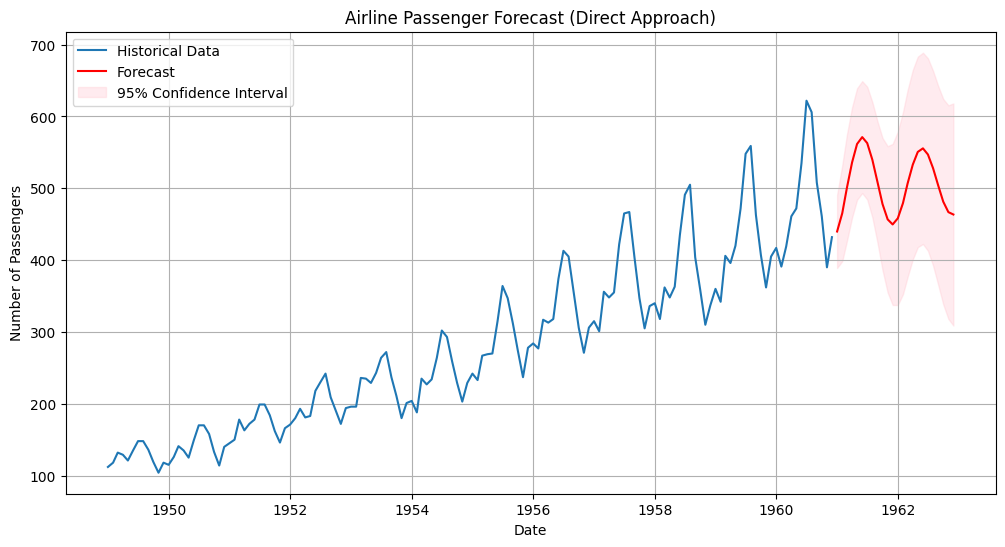

In [25]:
# Alternative approach: Direct forecasting without log transformation
forecast_steps = 24
model_direct = ARIMA(airpass_indexed, order=(2, 1, 2))
results_direct = model_direct.fit()

# Generate forecast directly
forecast_direct = results_direct.get_forecast(steps=forecast_steps)
forecast_values_direct = forecast_direct.predicted_mean
confidence_intervals_direct = forecast_direct.conf_int()

# Create the date range for forecasting
forecast_index = pd.date_range(
    start=airpass_indexed.index[-1],
    periods=forecast_steps+1,
    freq='MS'
)[1:]  # Skip the first date which is the last date of the original data

# Plot
plt.figure(figsize=(12, 6))
plt.plot(airpass_indexed, label='Historical Data')
plt.plot(forecast_index, forecast_values_direct, color='red', label='Forecast')
plt.fill_between(
    forecast_index,
    confidence_intervals_direct.iloc[:, 0],
    confidence_intervals_direct.iloc[:, 1],
    color='pink', alpha=0.3, label='95% Confidence Interval'
)
plt.title('Airline Passenger Forecast (Direct Approach)')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend(loc='best')
plt.grid(True)
plt.show()